In [2]:
! pip install yfinance

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import warnings
from tensorflow.keras.utils import get_file
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.layers import SimpleRNN

In [5]:
def data_to_X_y(temp, window_size=5):
  data_as_np=temp.to_numpy()
  X = []
  y = []
  for i in range(len(data_as_np)-window_size):
    row = [[a] for a in data_as_np[i:i+5]]
    X.append(row)
    label = data_as_np[i+5]
    y.append(label)
  return np.array(X), np.array(y)

In [6]:
def train_test_val_split(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
  print('Train Set: ', X_train.shape, y_train.shape)
  print('Test Set: ', X_test.shape, y_test.shape)
  return X_train, X_test, y_train, y_test

In [7]:
# Performance Metric
def metric(model, X_test, y_test):
  yhat=model.predict(X_test)
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]

In [8]:
score_dict={}

# **Climate Data**

In [ ]:
# Download and load the dataset
zip_path = get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
data = pd.read_csv(csv_path)

13568290/13568290 [==============================] - 2s 0us/step


In [ ]:
data.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1


<Axes: xlabel='Date Time'>

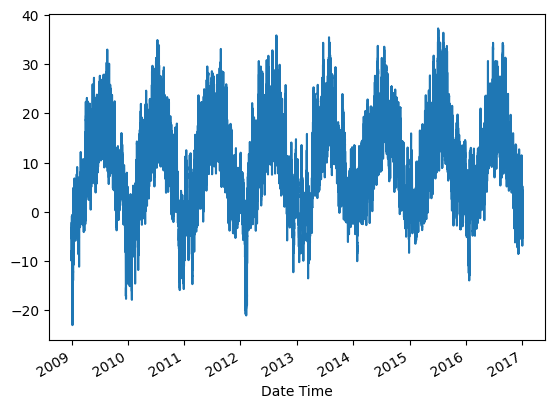

In [ ]:
data.index = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S')
temp =data['T (degC)']
temp.plot()

In [ ]:
WINDOW_SIZE=5
X, y=data_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape
X_train, X_test, y_train, y_test=train_test_val_split(X, y)

Train Set:  (294382, 5, 1) (294382,)
Test Set:  (126164, 5, 1) (126164,)


## **LSTM**

In [ ]:
model = Sequential()
model.add(LSTM(128, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(24))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/10
9200/9200 [==============================] - 159s 16ms/step - loss: 0.2489 - val_loss: 0.0452
Epoch 2/10
9200/9200 [==============================] - 157s 17ms/step - loss: 0.0504 - val_loss: 0.0459
Epoch 3/10
9200/9200 [==============================] - 145s 16ms/step - loss: 0.0485 - val_loss: 0.0508
Epoch 4/10
9200/9200 [==============================] - 145s 16ms/step - loss: 0.0476 - val_loss: 0.0493
Epoch 5/10
9200/9200 [==============================] - 145s 16ms/step - loss: 0.0472 - val_loss: 0.0454
Epoch 6/10
9200/9200 [==============================] - 142s 15ms/step - loss: 0.0469 - val_loss: 0.0440
Epoch 7/10
9200/9200 [==============================] - 146s 16ms/step - loss: 0.0465 - val_loss: 0.0427
Epoch 8/10
9200/9200 [==============================] - 154s 17ms/step - loss: 0.0464 - val_loss: 0.0430
Epoch 9/10
9200/9200 [==============================] - 152s 17ms/step - loss: 0.0462 - val_loss: 0.0421
Epoch 10/10
9200/9200 [==============================] 

In [ ]:
LSTM_=metric(model, X_test, y_test)
score_dict['LSTM_Climate']= LSTM_

3943/3943 [==============================] - 12s 3ms/step
RMSE 0.20634669662634755
MSE 0.04257895920860591
MAE 0.13012931496591842


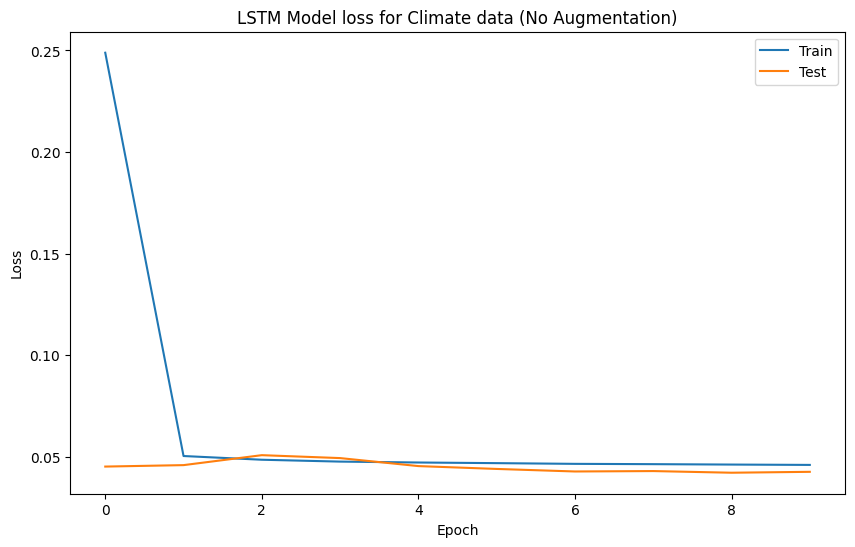

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model loss for Climate data (No Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

9200/9200 [==============================] - 29s 3ms/step


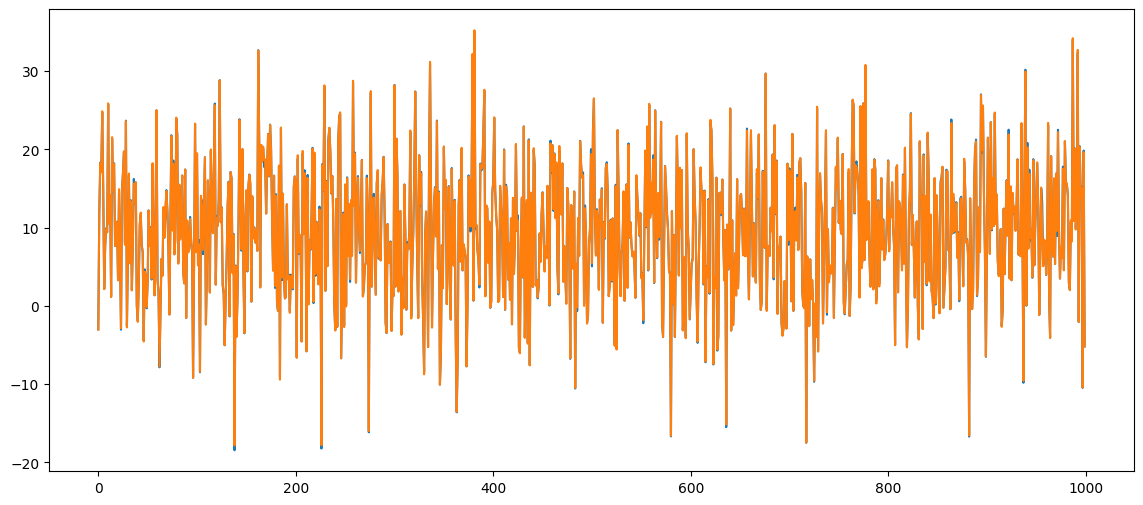

In [ ]:
train_predictions_lstm=model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions_lstm, 'Actuals': y_train})
train_results.index=temp.head(294382).index
plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

3943/3943 [==============================] - 13s 3ms/step


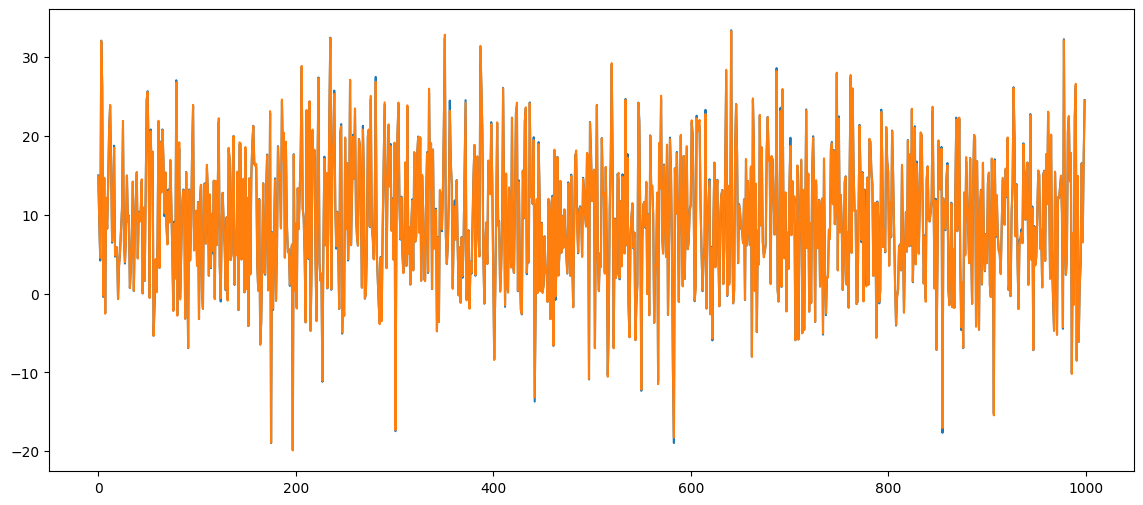

In [ ]:
test_predictions_lstm=model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions_lstm, 'Actuals': y_test})
test_results.index=temp.tail(126164).index
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **RNN**

In [ ]:
# Performance Metric
def metric_(y_test, test_predictions):
  yhat=test_predictions
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]


# Fit an ARIMA model
import statsmodels.api as sm
p, d, q = 1, 1, 1  # Example values, you may need to adjust these
arima_model = sm.tsa.ARIMA(temp, order=(p, d, q))
# Assuming you have already fitted the ARIMA model
arima_results = arima_model.fit()  # Fit the ARIMA model, you may have different parameters

# Get predictions on the training data
train_predictions_arima = arima_results.predict(start=0, end=len(X_train)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
train_results = pd.DataFrame({'Train Predictions': train_predictions_arima, 'Actuals': y_train})

# Get predictions on the training data
test_predictions_arima = arima_results.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
test_results = pd.DataFrame({'Test Predictions': test_predictions_arima , 'Actuals': y_test})

arima=metric_(y_test, test_predictions_arima  )
score_dict['ARIMA_Climate']= arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

RMSE 11.495427974719277
MSE 132.14486432195855
MAE 9.218162830856533


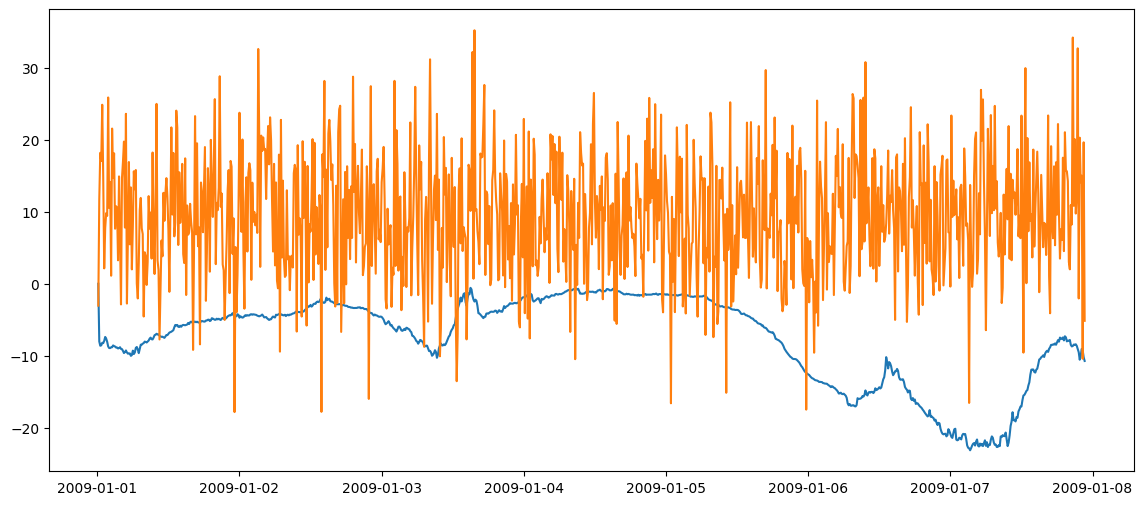

In [ ]:

plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

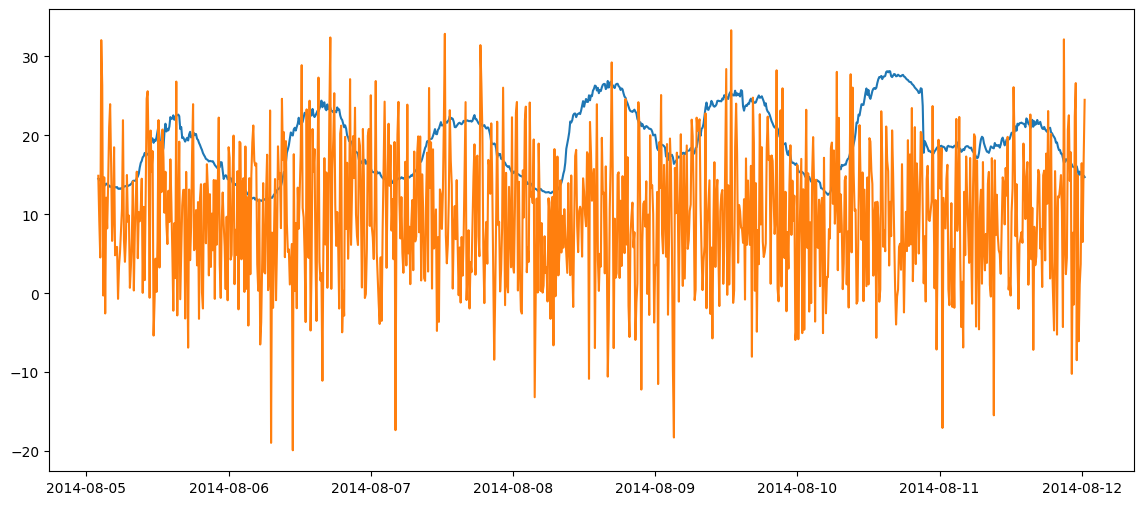

In [ ]:

plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **Stacking**

In [ ]:
from sklearn.linear_model import LinearRegression
Lr=LinearRegression ()
df_train=pd.DataFrame({'LSTM': train_predictions_lstm, 'RNN': train_predictions_arima})
Lr.fit(df_train, y_train)
df_test=pd.DataFrame({'LSTM': test_predictions_lstm, 'RNN': test_predictions_arima})
stacked_=metric(Lr, df_test, y_test)
score_dict['Stacked_Climate']= stacked_

RMSE 0.20587892483272774
MSE 0.04238613169027996
MAE 0.12962366500063335


# **Crypto Dataset (USDT)**

In [ ]:
# Get bitcoin data
data=  yf.Ticker("USDT-USD").history(interval='1d', start='2000-01-01', end='2022-12-31').reset_index()
data.head(2)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2017-11-09 00:00:00+00:00,1.01087,1.01327,0.996515,1.00818,358188000,0.0,0.0
1,2017-11-10 00:00:00+00:00,1.00650,1.02423,0.995486,1.00601,756446016,0.0,0.0


<Axes: xlabel='Date'>

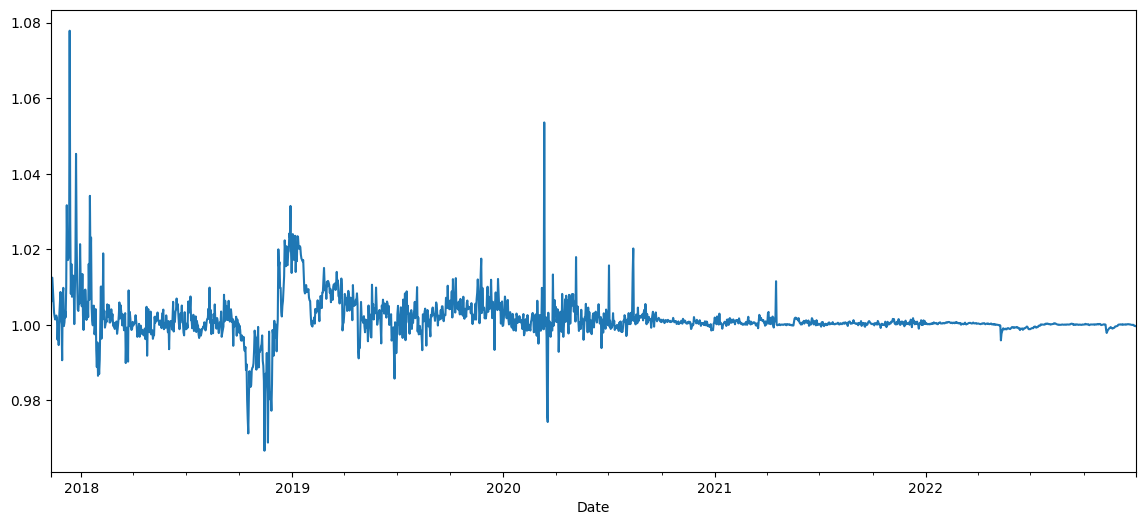

In [ ]:
data.index = pd.to_datetime(data['Date'], format='%d.%m.%Y %H:%M:%S')
plt.figure(figsize=(14, 6))
usdt=data['Close']
usdt.plot()

In [ ]:
X, y=data_to_X_y(usdt, WINDOW_SIZE)
X.shape, y.shape
X_train, X_test, y_train, y_test=train_test_val_split(X, y)

Train Set:  (1311, 5, 1) (1311,)
Test Set:  (562, 5, 1) (562,)


## **LSTM**

In [ ]:
model = Sequential()
model.add(LSTM(32, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/10
41/41 [==============================] - 2s 18ms/step - loss: 0.6377 - val_loss: 0.3436
Epoch 2/10
41/41 [==============================] - 1s 26ms/step - loss: 0.1165 - val_loss: 0.0042
Epoch 3/10
41/41 [==============================] - 1s 28ms/step - loss: 0.0016 - val_loss: 4.0414e-05
Epoch 4/10
41/41 [==============================] - 1s 24ms/step - loss: 2.9309e-05 - val_loss: 1.6325e-05
Epoch 5/10
41/41 [==============================] - 1s 28ms/step - loss: 1.8127e-05 - val_loss: 1.6121e-05
Epoch 6/10
41/41 [==============================] - 1s 28ms/step - loss: 1.7941e-05 - val_loss: 1.6352e-05
Epoch 7/10
41/41 [==============================] - 1s 26ms/step - loss: 1.7955e-05 - val_loss: 1.6408e-05
Epoch 8/10
41/41 [==============================] - 1s 13ms/step - loss: 1.7957e-05 - val_loss: 1.6414e-05
Epoch 9/10
41/41 [==============================] - 1s 14ms/step - loss: 1.7956e-05 - val_loss: 1.6394e-05
Epoch 10/10
41/41 [==============================] - 1s 1

In [ ]:
LSTM_=metric(model, X_test, y_test)
score_dict['LSTM_USDT']= LSTM_

18/18 [==============================] - 0s 3ms/step
RMSE 0.004044581097969993
MSE 1.635863625805615e-05
MAE 0.00214620756509041


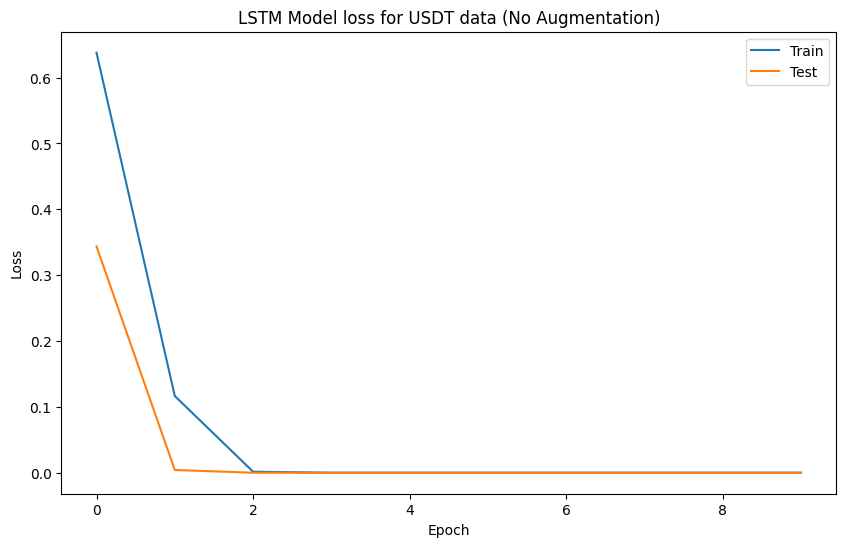

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model loss for USDT data (No Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

41/41 [==============================] - 0s 3ms/step


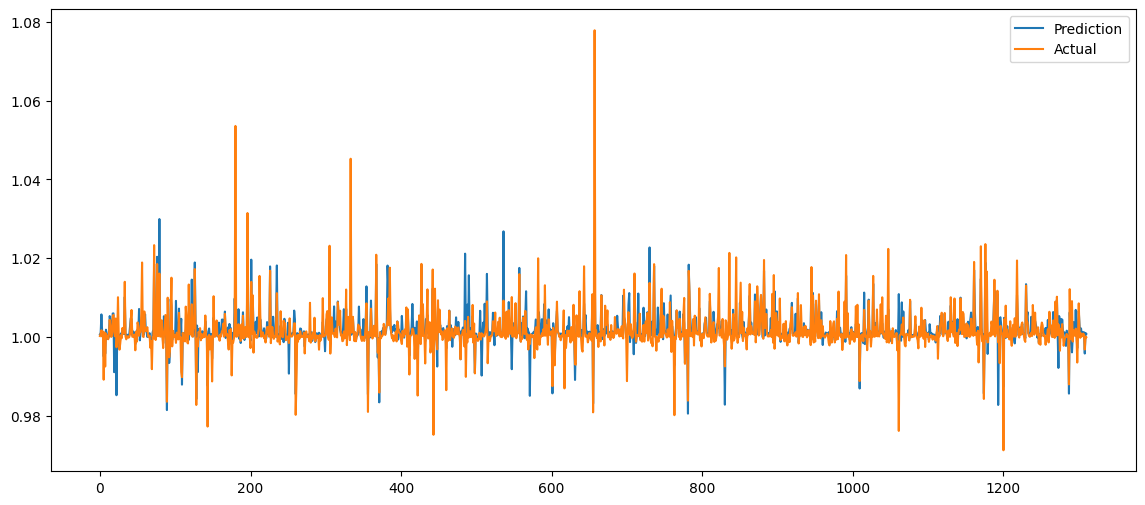

In [ ]:
train_predictions_lstm=model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions_lstm, 'Actuals': y_train})
train_results.index=usdt.head(1311).index
plt.figure(figsize=(14, 6))
plt.plot(train_results['Train Predictions'], label='Prediction')
plt.plot(train_results['Actuals'], label='Actual')
plt.legend()

18/18 [==============================] - 0s 3ms/step


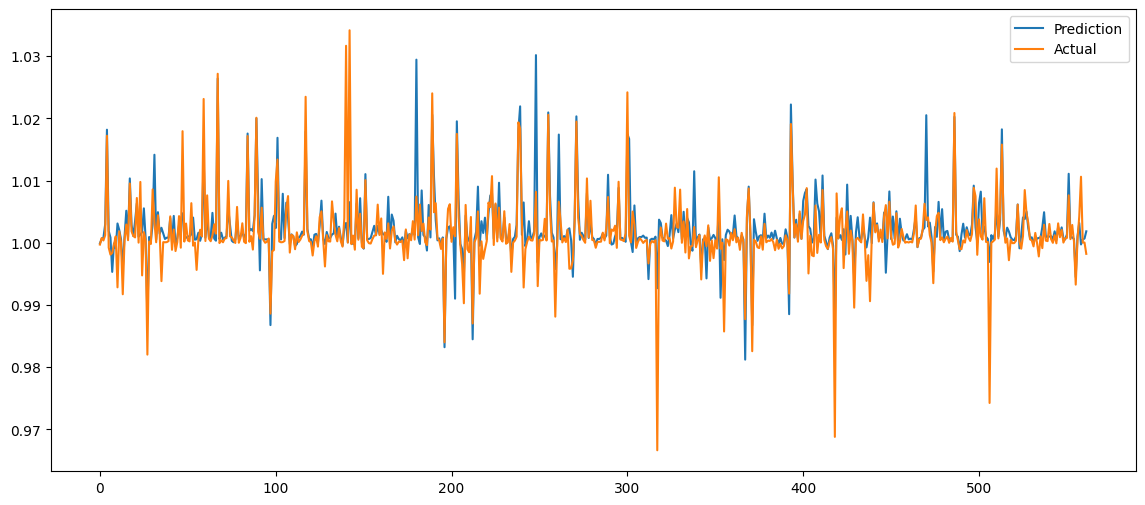

In [ ]:
test_predictions_lstm=model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions_lstm, 'Actuals': y_test})
test_results.index=usdt.tail(562).index
plt.figure(figsize=(14, 6))
plt.plot(test_results['Test Predictions'], label='Prediction')
plt.plot(test_results['Actuals'], label='Actual')
plt.legend()

## **RNN**

In [ ]:
# Performance Metric
def metric_(y_test, test_predictions):
  yhat=test_predictions
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]


# Fit an ARIMA model
import statsmodels.api as sm
p, d, q = 1, 1, 1  # Example values, you may need to adjust these
arima_model = sm.tsa.ARIMA(usdt, order=(p, d, q))
# Assuming you have already fitted the ARIMA model
arima_results = arima_model.fit()  # Fit the ARIMA model, you may have different parameters

# Get predictions on the training data
train_predictions_arima = arima_results.predict(start=0, end=len(X_train)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
train_results = pd.DataFrame({'Train Predictions': train_predictions_arima, 'Actuals': y_train})

# Get predictions on the training data
test_predictions_arima = arima_results.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
test_results = pd.DataFrame({'Test Predictions': test_predictions_arima , 'Actuals': y_test})

arima=metric_(y_test, test_predictions_arima  )
score_dict['ARIMA_USDT']= arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE 0.005904041604252216
MSE 3.485770726474108e-05
MAE 0.003121189563485748


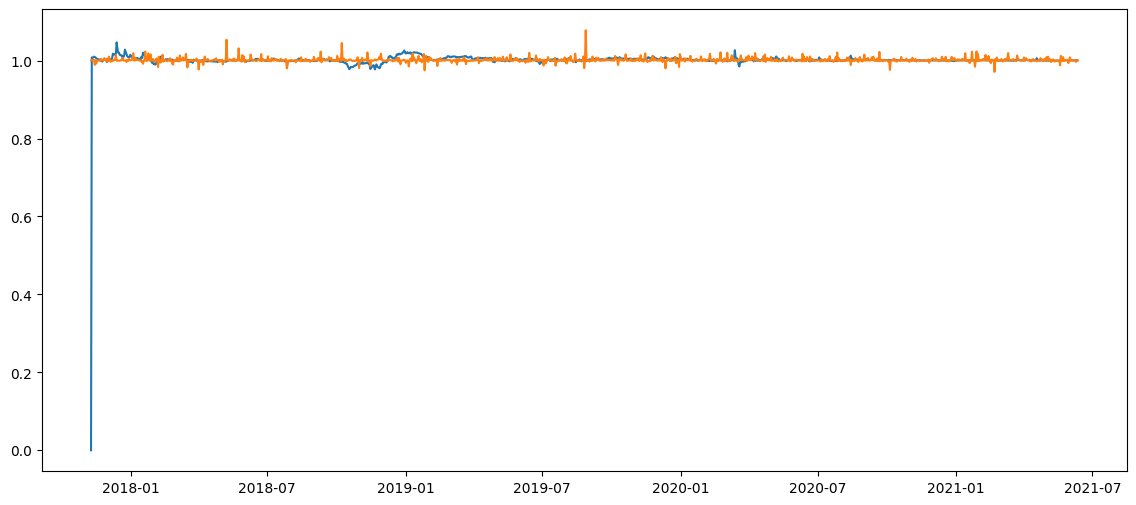

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

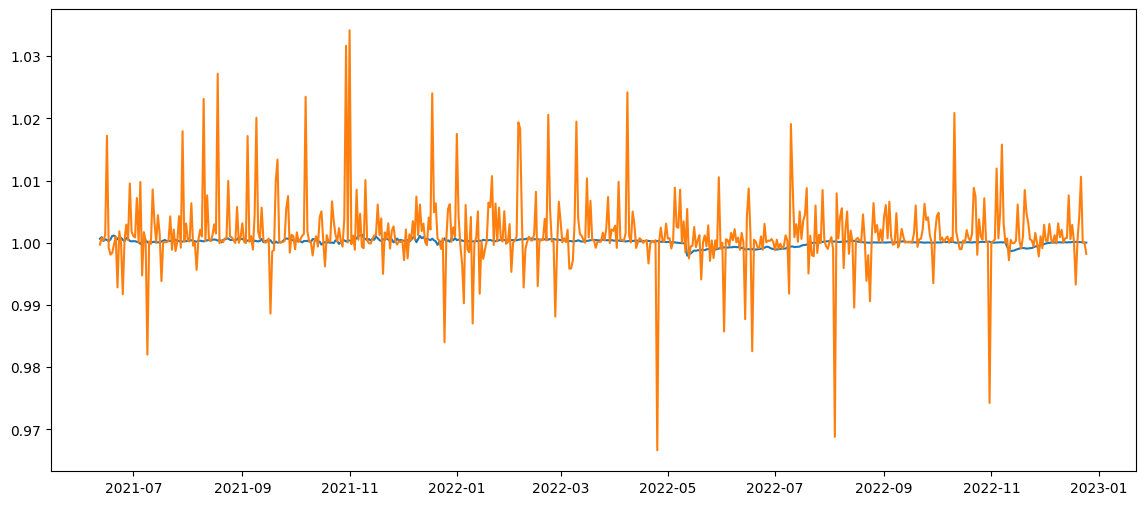

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

## **Stacking**

In [ ]:
Lr=LinearRegression ()
df_train=pd.DataFrame({'LSTM': train_predictions_lstm, 'RNN': train_predictions_arima})
Lr.fit(df_train, y_train)
df_test=pd.DataFrame({'LSTM': test_predictions_lstm, 'RNN': test_predictions_arima})
stacked_=metric(Lr, df_test, y_test)
score_dict['Stacked_USDT']= stacked_

RMSE 0.0039376625065626345
MSE 1.5505186015589127e-05
MAE 0.002027820469772633


# **Plant Sensor Data**

In [9]:
df=pd.read_csv('/content/drive/MyDrive/measures.csv')
df.head()

,mp,temperature,humidity,moisture,light,date,time
0,n1,24.7,57.9,1995,0.0,2022-09-15,00:00:04
1,n1,24.7,58.0,1991,0.0,2022-09-15,00:00:09
2,n1,24.7,58.2,1994,0.0,2022-09-15,00:00:14
3,n1,24.6,58.0,1993,0.0,2022-09-15,00:00:19
4,n1,24.6,58.0,1986,0.0,2022-09-15,00:00:25


In [10]:
df.date=pd.to_datetime(df['date'] + ' ' + df['time'])
df.index = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M:%S')

<Axes: xlabel='date'>

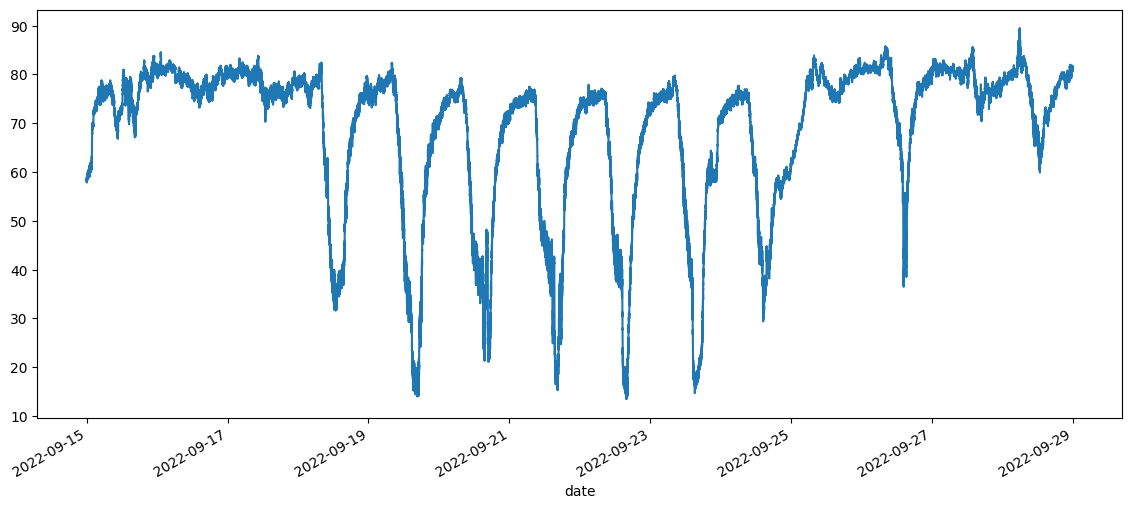

In [11]:
plt.figure(figsize=(14, 6))
humidity=df['humidity']
humidity.plot()

In [12]:
WINDOW_SIZE=5
X, y=data_to_X_y(humidity, WINDOW_SIZE)
X.shape, y.shape
X_train, X_test, y_train, y_test=train_test_val_split(X, y)

Train Set:  (163782, 5, 1) (163782,)
Test Set:  (70193, 5, 1) (70193,)


## **LSTM**

In [13]:
model = Sequential()
model.add(LSTM(16, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/10
5119/5119 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 500.9414 - val_loss: 0.0426
Epoch 2/10
5119/5119 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 0.0514 - val_loss: 0.0581
Epoch 3/10
5119/5119 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.0510 - val_loss: 0.0467
Epoch 4/10
5119/5119 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0496 - val_loss: 0.0423
Epoch 5/10
5119/5119 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0482 - val_loss: 0.0606
Epoch 6/10
5119/5119 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0489 - val_loss: 0.0357
Epoch 7/10
5119/5119 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0453 - val_loss: 0.0404
Epoch 8/10
5119/5119 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0449 - val_loss: 0.0439
Epoch 9/10
5119/5119 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0441 - val_loss: 0.0406
Epoch 10/10
5119/5119 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0446 - val_loss: 0.0370


In [14]:
LSTM_=metric(model, X_test, y_test)
score_dict['LSTM_Humidty']= LSTM_

2194/2194 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
RMSE 0.19232421037967115
MSE 0.03698860189816401
MAE 0.13689148872880577


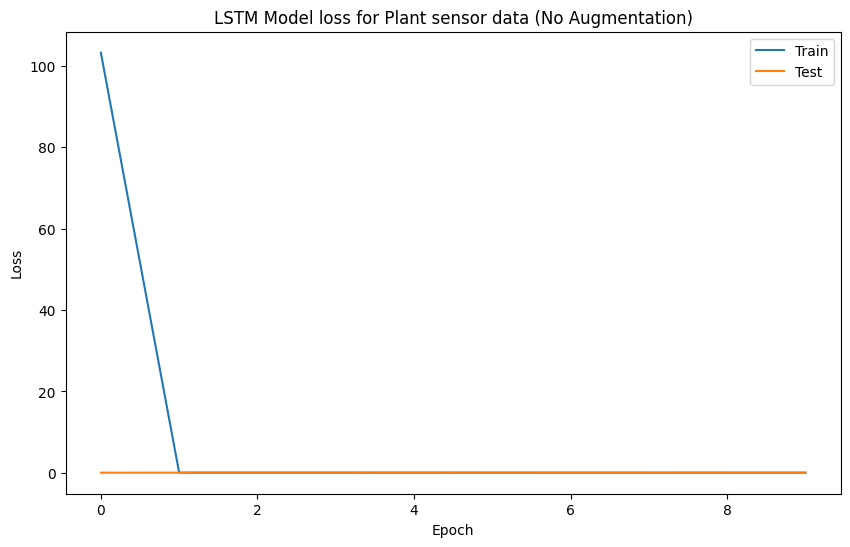

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model loss for Plant sensor data (No Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

5119/5119 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


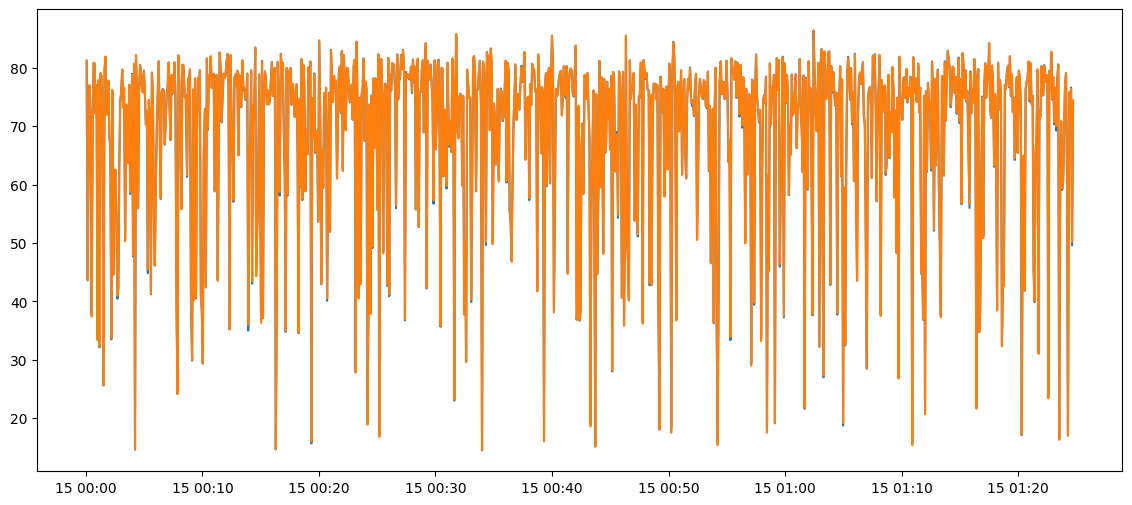

In [16]:
train_predictions_lstm=model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions_lstm, 'Actuals': y_train})
train_results.index=humidity.head(163782).index
plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

2194/2194 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


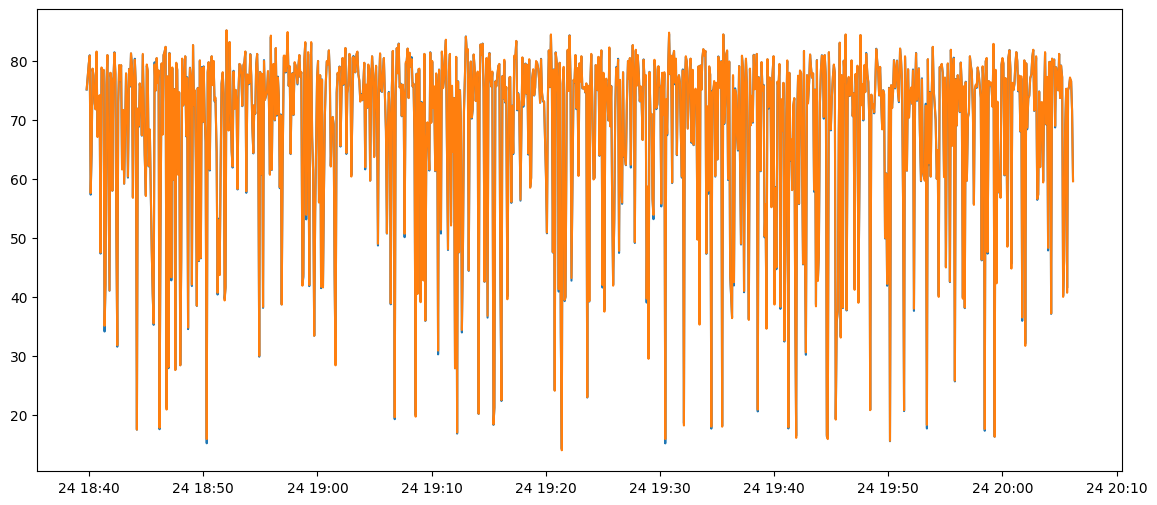

In [17]:
test_predictions_lstm=model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions_lstm, 'Actuals': y_test})
test_results.index=humidity.tail(70193).index
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **ARIMA**

In [18]:
# Performance Metric
def metric_(y_test, test_predictions):
  yhat=test_predictions
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]


# Fit an ARIMA model
import statsmodels.api as sm
p, d, q = 1, 1, 1  # Example values, you may need to adjust these
arima_model = sm.tsa.ARIMA(humidity, order=(p, d, q))
# Assuming you have already fitted the ARIMA model
arima_results = arima_model.fit()  # Fit the ARIMA model, you may have different parameters

# Get predictions on the training data
train_predictions_arima = arima_results.predict(start=0, end=len(X_train)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
train_results = pd.DataFrame({'Train Predictions': train_predictions_arima, 'Actuals': y_train})

# Get predictions on the training data
test_predictions_arima = arima_results.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
test_results = pd.DataFrame({'Test Predictions': test_predictions_arima , 'Actuals': y_test})

arima=metric_(y_test, test_predictions_arima  )
score_dict['ARIMA_Humidity']= arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RMSE 18.484512788618378
MSE 341.67721303259634
MAE 12.194946207683127


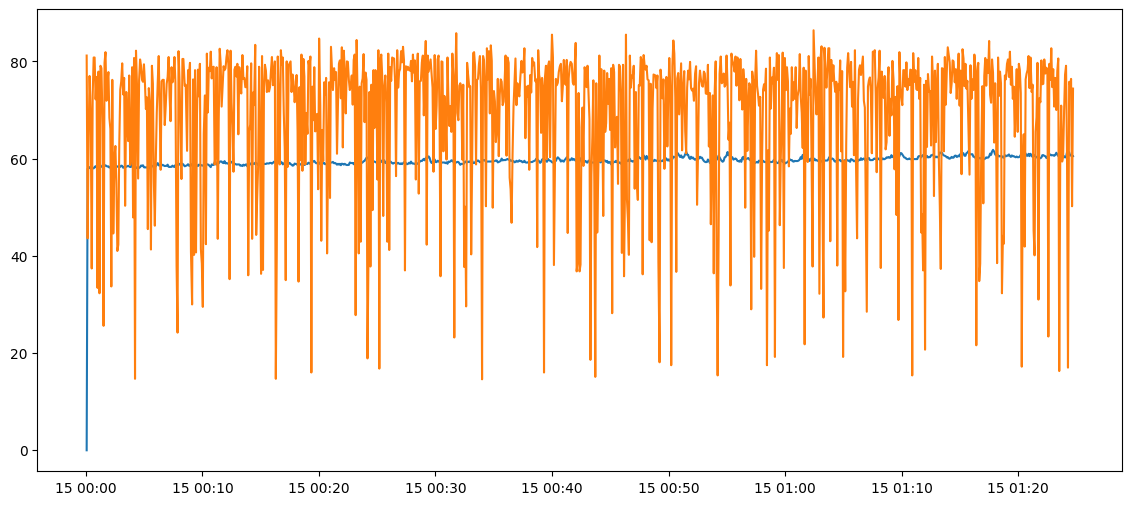

In [19]:
plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

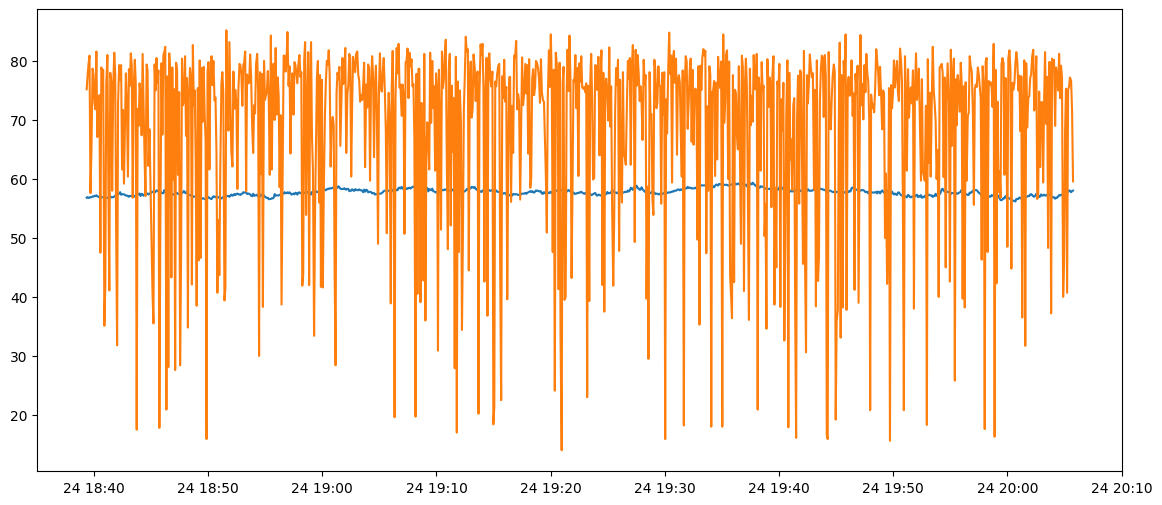

In [20]:
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **Stacking**

In [ ]:
from sklearn.linear_model import LinearRegression
Lr=LinearRegression ()
df_train=pd.DataFrame({'LSTM': train_predictions_lstm, 'RNN': train_predictions_arima})
Lr.fit(df_train, y_train)
df_test=pd.DataFrame({'LSTM': test_predictions_lstm, 'RNN': test_predictions_arima})
stacked_=metric(Lr, df_test, y_test)
score_dict['Stacked_Humidity']= stacked_

RMSE 0.17963066266992378
MSE 0.03226717497123595
MAE 0.12071940178238932


In [21]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming LSTM and ARIMA predictions are already obtained and stored
# For training
df_train = pd.DataFrame({
    'LSTM': train_predictions_lstm,
    'ARIMA': train_predictions_arima
})
y_train = np.array(y_train)  # Ensure y_train is a numpy array

# For testing
df_test = pd.DataFrame({
    'LSTM': test_predictions_lstm,
    'ARIMA': test_predictions_arima
})
y_test = np.array(y_test)  # Ensure y_test is a numpy array

# Simple Averaging Ensemble (SAE)
def simple_averaging(df):
    return df.mean(axis=1)

# Weighted Averaging Ensemble (WAE)
def weighted_averaging(df, weights):
    return np.dot(df, weights)

# Calculate SAE predictions
sae_predictions = simple_averaging(df_test)

# Calculate WAE predictions
# Example weights based on performance metrics from metric() function
weights = [0.5, 0.5]  # Example weights, should be based on the model's performance

wae_predictions = weighted_averaging(df_test, weights)

# Metrics calculation function
def calculate_metrics(y_true, y_pred):
    RMSE = mean_squared_error(y_true, y_pred, squared=False)
    MSE = mean_squared_error(y_true, y_pred)
    MAE = mean_absolute_error(y_true, y_pred)
    return [RMSE, MSE, MAE]

# Calculate metrics for SAE
sae_metrics = calculate_metrics(y_test, sae_predictions)
score_dict['SAE_Climate'] = sae_metrics

# Calculate metrics for WAE
wae_metrics = calculate_metrics(y_test, wae_predictions)
score_dict['WAE_Climate'] = wae_metrics

# Print out metrics
print(f'SAE Metrics: RMSE = {sae_metrics[0]}, MSE = {sae_metrics[1]}, MAE = {sae_metrics[2]}')
print(f'WAE Metrics: RMSE = {wae_metrics[0]}, MSE = {wae_metrics[1]}, MAE = {wae_metrics[2]}')

SAE Metrics: RMSE = 9.230461375210878, MSE = 85.2014171992599, MAE = 6.086054456132464
WAE Metrics: RMSE = 9.230461375210878, MSE = 85.2014171992599, MAE = 6.086054456132464


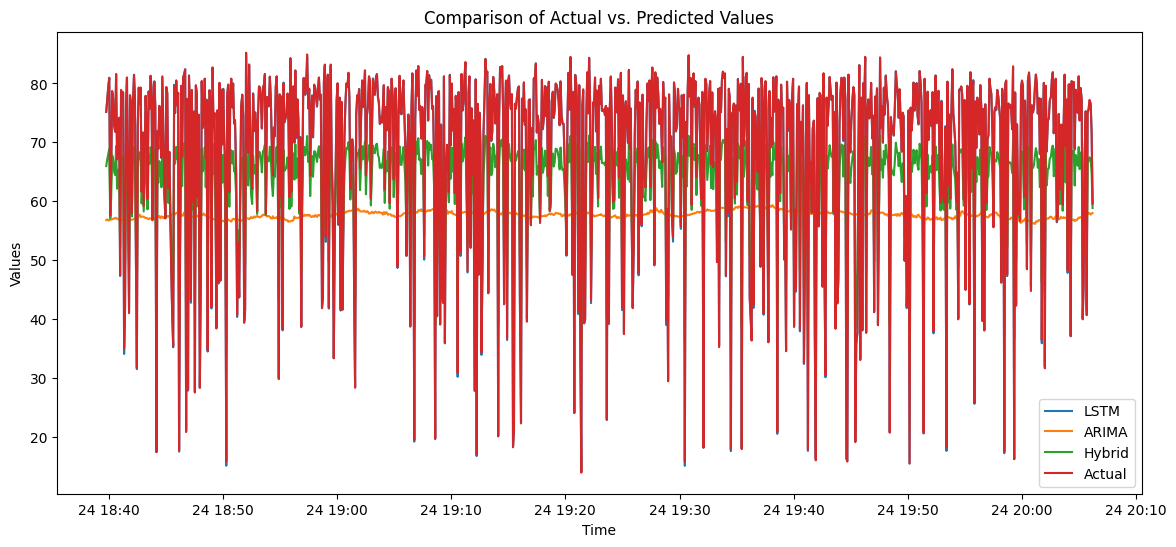

In [22]:
predictions_dict = {
    'LSTM Predictions': test_predictions_lstm,
    'ARIMA Predictions': test_predictions_arima,
    'Hybrid Predictions': wae_predictions,
    'Actual': y_test
}

test_results = pd.DataFrame(predictions_dict)
test_results.index=humidity.tail(70193).index
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['LSTM Predictions'], label="LSTM")
plt.plot(test_results.head(1000)['ARIMA Predictions'], label="ARIMA")
plt.plot(test_results.head(1000)['Hybrid Predictions'], label="Hybrid")
plt.plot(test_results.head(1000)['Actual'], label="Actual")
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Comparison of Actual vs. Predicted Values')
plt.show()

# **Results**

In [ ]:
Result=pd.DataFrame(score_dict).T
Result.columns=['RMSE', 'MSE', 'MAE']
Result[ 'Dat']=Result.index.str.split('_')
Result['Data']=Result[ 'Dat'].str[1]
Result['Model']=Result['Dat'].str[0]
Result.drop('Dat', axis=1, inplace=True)
Result=Result.set_index('Data')
Result=Result[['Model', 'RMSE', 'MSE', 'MAE']]
Result.to_csv('/content/drive/MyDrive/New TS DA/No_Augmentation.csv')